# **Análise Socio-Demográfica**

#### Este notebook tem como objetivo realizar uma análise socioeconômica e demográfica, com foco em um período de 3 meses. O propósito é explorar dados relevantes relacionados a características sociodemográficas da população e suas mudanças ao longo de um período de 3 meses, a ser validado dentro desse notebook.

## A análise visa responder a diversas perguntas, como:

* Como as características demográficas, como idade, gênero, raça/cor, escolaridade e área de domicílio, estão distribuídas na população?
* Existe alguma tendência nas mudanças demográficas ao longo desses 3 meses?
* Qual é a situação do mercado de trabalho e da renda das pessoas dentro deste período?
* Como os sintomas de saúde, como febre, dificuldade respiratória e fadiga, estão relacionados com as características sociodemográficas?
* Há uma relação entre a situação de domicílio e o resultado da COVID-19?
* Por meio dessa análise, pretendemos obter insights que podem ser úteis para tomada de decisão, formulação de políticas públicas e compreensão de tendências sociodemográficas, especialmente em um contexto de pandemia.

# **Preparando o ambiente**

In [5]:
# Criando estrutura para trabalhar dentro dos arquivos do git

!git clone https://github.com/pehls/gp27_techchallenge_3.git

fatal: destination path 'gp27_techchallenge_3' already exists and is not an empty directory.


In [6]:
!pip freeze > ..//requirements.txt

In [7]:
# Instalando google-cloud-bigquery para acessar os dados deste ambiente

!pip install google-cloud-bigquery

In [8]:
# Acessando a "tabela tratada" para o início da análise de dados
from google.cloud import bigquery

# Inserindo credenciais do projeto no BQ
credentials_path = '/content/gp27_techchallenge_3/credentials_fiap-tech-challenge-3.json'
client = bigquery.Client.from_service_account_json(credentials_path)

# Especificando o projeto e o conjunto de dados que contém a tabela.
project_id = 'fiap-tech-challenge-3'
dataset_id = 'trusted_pnad'
table_id = 'tb_f_covid_2020'

query = f'SELECT * FROM `{project_id}.{dataset_id}.{table_id}`'
query_job = client.query(query)
df = query_job.to_dataframe()

df.head()

,uf,semana_mes,mes,area_domicilio,idade,sexo,cor_raca,escolaridade,teve_febre,teve_dificuldade_respirar,...,teve_fadiga,teve_perda_cheiro,foi_posto_saude,ficou_em_casa,ficou_internado,tem_plano_saude,resultado_covid,assalariado,faixa_rendimento,situacao_domicilio
0,Minas Gerais,1,10,Rural,30,Feminino,Parda,Médio completo,Não,Não,...,Não,Não,NA,NA,NA,Não,NA,NA,NA,Cedido por familiar
1,Minas Gerais,1,10,Rural,41,Feminino,Parda,Médio completo,Não,Não,...,Não,Não,NA,NA,NA,Não,NA,NA,NA,Próprio - já pago
2,Minas Gerais,1,10,Rural,18,Masculino,Parda,Médio completo,Não,Não,...,Não,Não,NA,NA,NA,Não,NA,Não,801 - 1.600,Próprio - já pago
3,Minas Gerais,1,10,Rural,22,Masculino,Parda,Médio completo,Não,Não,...,Não,Não,NA,NA,NA,Não,NA,NA,NA,Próprio - já pago
4,Minas Gerais,1,10,Rural,26,Feminino,Parda,Médio completo,Não,Não,...,Não,Não,NA,NA,NA,Não,NA,NA,NA,Próprio - já pago


# **Análises**

## Definição dos 3 meses a serem analisados

#### Para definirmos os meses a serem estudados, primeiro buscamos entender como os dados estão distribuídos por mês durante o ano de 2020 e quantos casos positivos tivemos em cada um deles

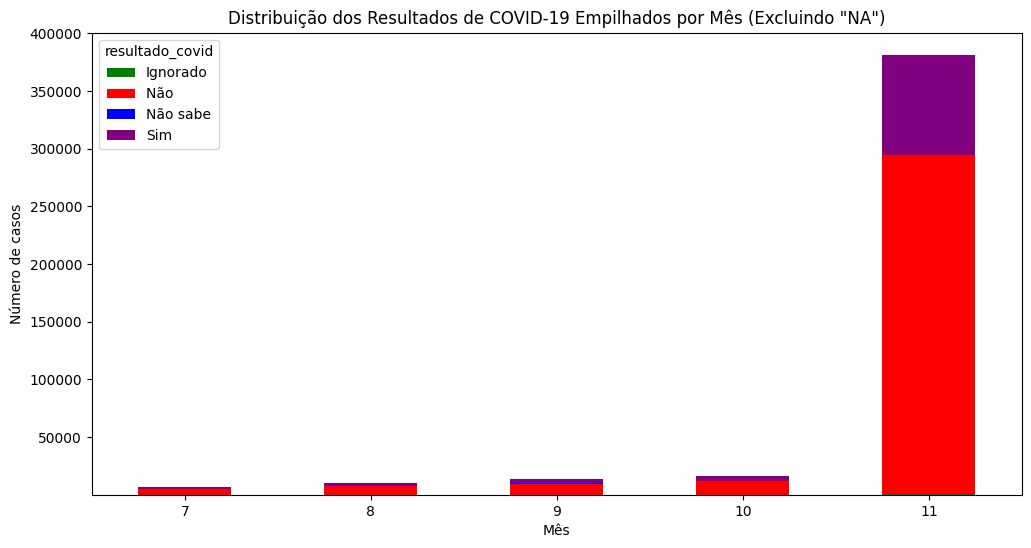

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

df_filtrado = df[df['resultado_covid'] != 'NA']

# Criando uma tabela cruzada para contar os resultados por mês.
crosstab = pd.crosstab(df_filtrado['mes'], df_filtrado['resultado_covid'])

# Criando um gráfico empilhado.
crosstab.plot(kind='bar', stacked=True, figsize=(12, 6), color=['green', 'red', 'blue', 'purple'])

plt.title('Distribuição dos Resultados de COVID-19 Empilhados por Mês (Excluindo "NA")')
plt.xlabel('Mês')
plt.ylabel('Número de casos')
plt.xticks(rotation=0)

plt.show()

#### Com base nos dados acima, é possível identificar que os 3 meses com uma quantidade de registros ccom o valor resultado_covid diferente de NA tem uma amostra mais relevante nos últimos 3 meses da comparação. Nesse caso, optamos por utilizar os meses de novembro(11), outubro(10) e setembro(9).

#### Abaixo vemos como os dados estão segmentados por "categoria" dentro do resultado_covid durante os meses citados

In [10]:
import pandas as pd

df_filtrado = df[df['resultado_covid'] != 'NA']

meses_selecionados = [9, 10, 11]
df_filtrado = df_filtrado[df_filtrado['mes'].isin(meses_selecionados)]

crosstab = pd.crosstab(df_filtrado['mes'], df_filtrado['resultado_covid'])

percentuais_por_mes = crosstab.apply(lambda row: (row / row.sum()) * 100, axis=1).T
percentuais_por_mes = percentuais_por_mes.round(2)

percentuais_por_mes.head()


mes,9,10,11
resultado_covid,,,
Ignorado,0.01,0.00,0.17
Não,70.89,70.56,76.99
Não sabe,0.64,0.52,0.00
Sim,28.46,28.92,22.85


# Análises Socio-demográficas - Resultados Positivos

#### No gráfico abaixo, poderemos visualizar qual é o percentual de cada "categoria" de cada coluna(feature) da tabela, que representam todas as pessoas que tiveram o resultado do covid positivo.

#### Obs: Removemos as colunas de mes, semana_mes e idade dessa visualização

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact

# Filtrar o DataFrame para incluir apenas os meses 9, 10 e 11
meses_selecionados = [9, 10, 11]
df_filtrado = df[df['mes'].isin(meses_selecionados)]

# Função para criar um gráfico interativo com percentuais
def criar_grafico(coluna):
    # Filtrar o DataFrame com base na coluna selecionada e remover valores "NA".
    df_filtrado_coluna = df_filtrado[(df_filtrado['resultado_covid'] == 'Sim') & (df_filtrado[coluna] != 'NA')]

    # Calcular a distribuição em percentuais.
    percentuais = df_filtrado_coluna[coluna].value_counts(normalize=True) * 100

    # Criar um gráfico de barras para mostrar a distribuição dos resultados de COVID-19 pela coluna selecionada.
    plt.figure(figsize=(20, 6))
    resultado_count = df_filtrado_coluna[coluna].value_counts()
    resultado_count.plot(kind='bar', color='skyblue')
    plt.title(f'Distribuição de Resultados positivos de COVID-19 por {coluna}')
    plt.xlabel(coluna)
    plt.ylabel('Percentual de casos (%)')
    plt.xticks(rotation=45)

    # Adicionar as porcentagens acima de cada barra.
    for i, valor in enumerate(resultado_count):
        plt.text(i, valor, f'{percentuais[i]:.2f}%', ha='center', va='bottom')

    plt.show()

# Lista de colunas disponíveis para análise (excluindo 'idade' e 'semana_mes')
colunas_disponiveis = [coluna for coluna in df.columns if coluna not in ['idade', 'semana_mes', 'resultado_covid', 'mes']]

# Widget de seleção para escolher a coluna
interact(criar_grafico, coluna=colunas_disponiveis)

interactive(children=(Dropdown(description='coluna', options=('uf', 'area_domicilio', 'sexo', 'cor_raca', 'esc…

<function __main__.criar_grafico(coluna)>

## Observações sobre as análises socio-demográficas - Resultados Positivos

* Gráficos sobre os **sintomas apresentados**:
  * Mais de 95% da população da pesquisa, em todos os sintomas, não apresentou nenhum dos sintomas estudados. São eles: febre, dificuldade de respirar, dores de cabeça, fadiga ou perda de olfato.

* Gráfico sobre **Plano de saúde**:

  * Mais de 55% da população que teve o resultado positivo para a COVID-19 não possuem plano de saúde, isso pode indicar que muito provavelmente dependerão do sistema público de saúde para tratarem de seus resultados e isso pode sobrecarregar o sistema em tempos de pandemia, como foi o caso na época em que a pandemia da COVID-19 estava em seus piores momentos.

  * Além disso, a ausência de plano de saúde também pode estar relacionada aos resultados da COVID-19. Pessoas sem plano de saúde podem ter menos acesso a testes ou tratamento médico, o que pode afetar os resultados e a detecção de casos.

* Gráfico **Cor-raça**:

  * Quase 58% das pessoas que possuem o resultado positivo são da cor-raça Branca. Isso pode indicar que a amostra de dados possui mais registros voltados para as regiões sudeste e sul do Brasil, onde históricamente a população se declara desta cor-raça.
  
  * Outra hipótese que pode embasar este número é que a disponibilidade de testes de COVID-19 e acesso a cuidados de saúde podem variar entre grupos raciais ou étnicos. Isso pode afetar a detecção de casos e a distribuição dos resultados positivos, especialmente nas regiões mais pobres do país.

# Análises Socio-demográficas - Resultados Negativos

#### No gráfico abaixo, poderemos visualizar qual é o percentual de cada "categoria" de cada coluna(feature) da tabela, que representam todas as pessoas que tiveram o resultado do covid negativo.

#### Obs: Removemos as colunas de mes, semana_mes e idade dessa visualização

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact

# Filtrar o DataFrame para incluir apenas os meses 9, 10 e 11
meses_selecionados = [9, 10, 11]
df_filtrado = df[df['mes'].isin(meses_selecionados)]

# Função para criar um gráfico interativo com percentuais
def criar_grafico(coluna):
    # Filtrar o DataFrame com base na coluna selecionada e remover valores "NA".
    df_filtrado_coluna = df_filtrado[(df_filtrado['resultado_covid'] == 'Não ') & (df_filtrado[coluna] != 'NA')]

    # Calcular a distribuição em percentuais.
    percentuais = df_filtrado_coluna[coluna].value_counts(normalize=True) * 100

    # Criar um gráfico de barras para mostrar a distribuição dos resultados de COVID-19 pela coluna selecionada.
    plt.figure(figsize=(20, 6))
    resultado_count = df_filtrado_coluna[coluna].value_counts()
    resultado_count.plot(kind='bar', color='skyblue')
    plt.title(f'Distribuição de Resultados negativos de COVID-19 por {coluna}')
    plt.xlabel(coluna)
    plt.ylabel('Percentual de casos (%)')
    plt.xticks(rotation=45)

    # Adicionar as porcentagens acima de cada barra.
    for i, valor in enumerate(resultado_count):
        plt.text(i, valor, f'{percentuais[i]:.2f}%', ha='center', va='bottom')

    plt.show()

# Lista de colunas disponíveis para análise (excluindo 'idade' e 'semana_mes')
colunas_disponiveis = [coluna for coluna in df.columns if coluna not in ['idade', 'semana_mes', 'resultado_covid', 'mes']]

# Widget de seleção para escolher a coluna
interact(criar_grafico, coluna=colunas_disponiveis)

interactive(children=(Dropdown(description='coluna', options=('uf', 'area_domicilio', 'sexo', 'cor_raca', 'esc…

<function __main__.criar_grafico(coluna)>

## Observações sobre as análises socio-demográficas - Resultados Negativos

* Gráficos sobre os **sintomas apresentados**:
  * Mais de 95% da população da pesquisa, em todos os sintomas, não apresentou nenhum dos sintomas estudados. São eles: febre, dificuldade de respirar, dores de cabeça, fadiga ou perda de olfato. O mesmo comportamento é visto entre os pacientes com o resultado covid positivo.

* Gráfico **Cor-raça**:

  * Quase 58% das pessoas que possuem o resultado negativo são da cor-raça Parda.

* Gráfico de **Escolaridade**:

  * 36% dos pacientes que apresentaram o resultado negativo possuem ensino fundamental incompleto.

  * Uma hipótese é que o grau de escolaridade/informação pode ter impacto na percepção desses pacientes sobre os sintomas, e por consequência, podem fazer o teste de maneira "equivocada"

## Análises - Idade